## Seguimiento 2

In [99]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest # Prueba de z de proporcines 
from scipy.stats import wilcoxon
from scipy.stats import binomtest
from statsmodels.stats.multitest import multipletests #para corrección bonferroni
from scipy.stats import ttest_ind #prueba t para dos muestras independientes 
from itertools import  combinations #combinaciones para prueba t de comparaciones multiples
from scipy.stats import ttest_rel #Prueba t para muestras pareadas o no independientes 
from scipy.stats import mannwhitneyu #Prueba U de Mann-Whitney 
from scipy.stats import kstest, norm, ttest_1samp
import numpy as np
from scipy.stats import kstest, norm, ttest_1samp, wilcoxon
from scipy.stats import boxcox
import seaborn as sns



In [3]:
csv = pd.read_csv("heart_attack_prediction_dataset.csv")

#### 1. ¿El valor promedio de colesterol de la muestra, correspondiente a pacientes  que sufrieron infarto, es menor 200mg/dL? Y en los pacientes que no sufrieron  infarto, ¿es menor 200mg/dL? 

#### a) 
H0: El valor promedio de colesterol de los pacientes que sufrieron infarto es mayor o igual a 200 mg/dL.

H1: El valor promedio de colesterol de los pacientes que sufrieron infarto es menor a 200 mg/dL.

#### alfa = 0.05

In [ ]:
ttk = csv.loc[csv["Heart Attack Risk"]==1,  "Cholesterol"].dropna()
ttkno = csv.loc[csv["Heart Attack Risk"]==0,  "Cholesterol"].dropna()

print(ttk.shape[0])
print(ttkno.shape[0])

3139
5624


#### Verificar Normalidad, como n>50 se usa Kolmogorov-Smirnoff

In [110]:
## Norml?
def test_normalityKS(data, variable):

    print(f"\n Análisis de normalidad por Kolmogorov-Smirnov para '{variable}'")

    ks_stat, ks_p = stats.kstest(data, 'norm', args=(np.mean(data), np.std(data)))
    print(f" Estadístico = {ks_stat:.4f}, p-valor = {ks_p}")
    if p_norm > a:
       print("No se rechaza normalidad")
    else:
       print("Se rechaza normalidad")

test_normalityKS(ttk, "Cholesterol")




 Análisis de normalidad por Kolmogorov-Smirnov para 'Cholesterol'
 Estadístico = 0.0633, p-valor = 2.1974196273317372e-11
Se rechaza normalidad


#### Se hace una transformación, Box - Cox

In [69]:
def box_cox(data):
    transformed_data, lambda_opt = stats.boxcox(data)
    b, l =  transformed_data, lambda_opt
    return b

b=box_cox(ttk)
test_normalityKS(b, "Cholesterol")


 Análisis de normalidad por Kolmogorov-Smirnov para 'Cholesterol'
 Estadístico = 0.0633, p-valor = 2.1559254984622445e-11
Se rechaza normalidad


#### No funcionó box-cox, graficamos para ver la distribución

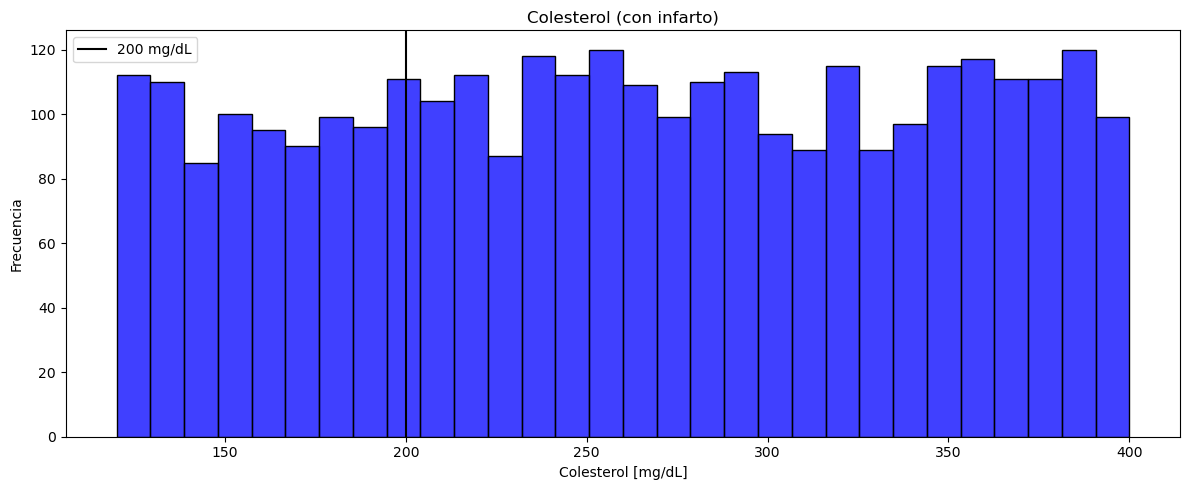

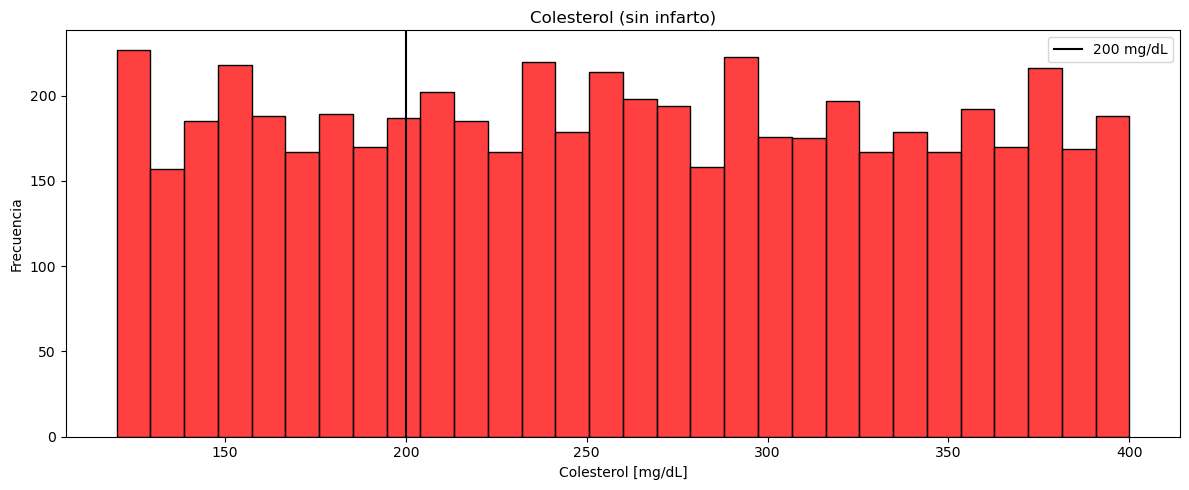

In [113]:
plt.figure(figsize=(12,5))
sns.histplot(ttk, color="blue", bins=30)
plt.axvline(200, color="black",  label="200 mg/dL")
plt.title(f"Colesterol (con infarto)")
plt.xlabel("Colesterol [mg/dL]")
plt.ylabel("Frecuencia")
plt.legend()

plt.tight_layout()
plt.figure(figsize=(12,5))
sns.histplot(ttkno, color="red", bins=30)
plt.axvline(200, color="black",  label="200 mg/dL")
plt.title(f"Colesterol (sin infarto)")
plt.xlabel("Colesterol [mg/dL]")
plt.ylabel("Frecuencia")
plt.legend()

plt.tight_layout()
plt.show()

#### Hay ue hacer una prueba no paramétrica (Wilcoxon) pues las graficas son muy homogéneas

In [124]:
def wilcoxon_test (nombre, data,mediana=0,y=None):# prueba Wilcoxon 

    stat, p_value = wilcoxon(data - mediana,y)
    
    print(f"Prueba para: {nombre}. Estadístico de Wilcoxon: {stat}, p-valor: {p_value}")
    return p_value
p = wilcoxon_test("Colesterol con infarto", ttk)
wilcoxon_test("Colesterol sin infarto", ttkno)

Prueba para: Colesterol con infarto. Estadístico de Wilcoxon: 0.0, p-valor: 0.0
Prueba para: Colesterol sin infarto. Estadístico de Wilcoxon: 0.0, p-valor: 0.0


0.0

In [ ]:
if p > 0.05:
    #rechaar Ho
    print("Se afirma H")

0.0


#### Verificr normlidd

In [93]:
###Normlidd
def test_normality(series, name="Variable", alpha=0.05):
    s = series.dropna()
    if len(s) <= 50:
        stat, p = shapiro(s)
        test_used = "Shapiro-Wilk"
    else:
        z = (s - s.mean()) / s.std(ddof=0)
        stat, p = kstest(z, "norm")
        test_used = "Kolmogorov-Smirnov"
    
    if p > alpha:
        print(f"{name}: {test_used} p={p} → Se asume normalidad (no se rechaza H0).")
    else:
        print(f"{name}: {test_used} p={p} → No es normal (se rechaza H0).")
    return p
test_normality(ttk)
test_normality(ttkno)

Variable: Kolmogorov-Smirnov p=2.1974196273317372e-11 → No es normal (se rechaza H0).
Variable: Kolmogorov-Smirnov p=1.2613526786008846e-16 → No es normal (se rechaza H0).


1.2613526786008846e-16

In [ ]:
#grficr



#### No es norml ninguno, hcer trnsformción Box - cox

In [ ]:
for group, label in [(1, "Con infarto"), (0, "Sin infarto")]:
    series = data.loc[data["Heart Attack Risk"] == group, "Cholesterol"].dropna()
    
    transformed, lam = boxcox(series)
    mu0_trans = boxcox([200], lmbda=lam)[0]
    
    print(f"\nGrupo: {label}")
    print(f" - n = {len(series)}")
    print(f" - Media original = {series.mean():.2f}")
    print(f" - λ Box-Cox óptimo = {lam:.3f}")
    
    test_normality(pd.Series(transformed), f"Cholesterol transformado ({label})")
    
    # Prueba t una muestra
    tstat, p_two = stats.ttest_1samp(transformed, mu0_trans, nan_policy="omit")
    p_one = p_two/2 if tstat < 0 else 1 - p_two/2
    
    if p_one < 0.05:
        print(f" - t={tstat:.3f}, p={p_one:.4f} → Se rechaza H0, la media < 200 mg/dL (significativo).")
    else:
        print(f" - t={tstat:.3f}, p={p_one:.4f} → No se rechaza H0, no hay evidencia de que la media < 200 mg/dL.")



Grupo: Con infarto
 - n = 3139
 - Media original = 261.97
 - λ Box-Cox óptimo = 0.810
Cholesterol transformado (Con infarto): Kolmogorov-Smirnov p=2.1559254984620535e-11 → No es normal (se rechaza H0).
 - t=41.959, p=1.0000 → No se rechaza H0, no hay evidencia de que la media < 200 mg/dL.

Grupo: Sin infarto
 - n = 5624
 - Media original = 258.71
 - λ Box-Cox óptimo = 0.727
Cholesterol transformado (Sin infarto): Kolmogorov-Smirnov p=4.05780352912829e-18 → No es normal (se rechaza H0).
 - t=52.373, p=1.0000 → No se rechaza H0, no hay evidencia de que la media < 200 mg/dL.


#### 3.

In [90]:

def test_homogeneity(s1, s2, name1="Grupo1", name2="Grupo2", alpha=0.05):
    """
    Verifica igualdad de varianzas con Levene.
    """
    stat, p = stats.levene(s1.dropna(), s2.dropna())
    if p > alpha:
        print(f"Levene entre {name1} y {name2}: p={p:.4f} → Se asume igualdad de varianzas.")
    else:
        print(f"Levene entre {name1} y {name2}: p={p:.4f} → Varianzas diferentes.")
    return p
# =====================
# PREGUNTA 3: Ejercicio vs Infarto
# =====================
print("\n--- Pregunta 3 (Horas de ejercicio entre grupos) ---")

e_inf = data.loc[data["Heart Attack Risk"] == 1, "Exercise Hours Per Week"].dropna()
e_no  = data.loc[data["Heart Attack Risk"] == 0, "Exercise Hours Per Week"].dropna()

print(f"n infarto = {len(e_inf)}, n no infarto = {len(e_no)}")
print(f"Media ejercicio (infarto) = {e_inf.mean():.2f}, (no infarto) = {e_no.mean():.2f}")

# Normalidad
p_inf = test_normality(e_inf, "Ejercicio (infarto)")
p_no  = test_normality(e_no, "Ejercicio (no infarto)")

# Homogeneidad
p_lev = test_homogeneity(e_inf, e_no, "Ejercicio (infarto)", "Ejercicio (no infarto)")

# Selección de prueba
if (p_inf > 0.05 and p_no > 0.05):
    tstat, pval = stats.ttest_ind(e_inf, e_no, equal_var=(p_lev > 0.05))
    if pval < 0.05:
        print(f"Prueba t: t={tstat:.3f}, p={pval:.4f} → Diferencia significativa en horas de ejercicio.")
    else:
        print(f"Prueba t: t={tstat:.3f}, p={pval:.4f} → No hay diferencia significativa en horas de ejercicio.")
else:
    u, pval = stats.mannwhitneyu(e_inf, e_no, alternative="two-sided")
    if pval < 0.05:
        print(f"Mann-Whitney U={u:.1f}, p={pval:.4f} → Diferencia significativa en horas de ejercicio.")
    else:
        print(f"Mann-Whitney U={u:.1f}, p={pval:.4f} → No hay diferencia significativa en horas de ejercicio.")


--- Pregunta 3 (Horas de ejercicio entre grupos) ---
n infarto = 3139, n no infarto = 5624
Media ejercicio (infarto) = 10.10, (no infarto) = 9.97
Ejercicio (infarto): Kolmogorov-Smirnov p=2.6657304139880403e-11 → No es normal (se rechaza H0).
Ejercicio (no infarto): Kolmogorov-Smirnov p=2.645633343652403e-18 → No es normal (se rechaza H0).
Levene entre Ejercicio (infarto) y Ejercicio (no infarto): p=0.4314 → Se asume igualdad de varianzas.
Mann-Whitney U=8945544.0, p=0.2959 → No hay diferencia significativa en horas de ejercicio.
